In [14]:
pip install pyod shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from pyod.models.alad import ALAD
import matplotlib.pyplot as plt
import seaborn as sn
import shap
from pickle import dump, load

#### Data Loading

In [16]:
df=pd.read_pickle('https://drive.google.com/uc?id=1hILz_vBupbUaEICj_Xgw933g5Har2hpW')

In [17]:
df.head()

,IDATE,LAT,LON,ELEVATION_m,PPT_mm,TMIN_c,TMEAN_c,TMAX_c,TDMEAN_c,lfmc_mean,lfmc_stdv,Mean_Sea_Level_Pressure,Mean_Station_Pressure,Mean_Wind_Speed,Maximum_Sustained_Wind_Speed,VPDMIN_hpa,VPDMAX_hpa
0,0.026572,0.256588,0.611242,0.252408,0.0,0.307359,0.377970,0.439271,0.350840,0.183593,0.234687,0.398496,0.917252,0.147619,0.200000,0.106533,0.234453
1,0.026572,0.306701,0.553827,0.267139,0.0,0.411255,0.431965,0.443320,0.487395,0.015900,0.099077,0.416040,0.913973,0.114286,0.211321,0.116937,0.207287
2,0.088574,0.177170,0.686698,0.265439,0.0,0.409091,0.460043,0.497976,0.449580,0.583804,0.335023,0.478697,0.928806,0.161905,0.290566,0.166875,0.245912
3,0.090345,0.650015,0.374516,0.460907,0.0,0.283550,0.280778,0.281377,0.279412,0.352868,0.308407,0.443609,0.790320,0.157143,0.222642,0.081149,0.144586
4,0.091231,0.113036,0.775809,0.553258,0.0,0.270563,0.269978,0.269231,0.250000,0.405914,0.409989,0.433584,0.953630,0.171429,0.211321,0.097794,0.118965


In [18]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=False)
#Labels for PyOD 0 = inlier, 1 = outlier 
y_train=np.zeros(X_train.shape[0])
y_test=np.zeros(X_test.shape[0])
print("Train set data size : "+str(X_train.shape))
print("Test set data size : "+str(X_test.shape))

Train set data size : (5868, 17)
Test set data size : (1467, 17)


#### Model Training

In [19]:
#estimator=ALAD(enc_layers=[17,10,5], dec_layers=[5,10,17], disc_xx_layers=[17,10,5], disc_zz_layers=[17,10,5], disc_xz_layers=[17,10,5], activation_hidden_disc='relu', activation_hidden_gen='relu', output_activation='sigmoid')
#estimator.fit(X_train)

In [20]:
#dump(estimator, open('14_CA_ALAD.pkl', 'wb'))
estimator=load(open('14_CA_ALAD.pkl', 'rb'))
estimator

ALAD(activation_hidden_disc='relu', activation_hidden_gen='relu',
   add_disc_zz_loss=True, add_recon_loss=False, batch_size=32,
   contamination=0.1, dec_layers=[5, 10, 17], disc_xx_layers=[17, 10, 5],
   disc_xz_layers=[17, 10, 5], disc_zz_layers=[17, 10, 5],
   dropout_rate=0.2, enc_layers=[17, 10, 5], epochs=200,
   lambda_recon_loss=0.1, latent_dim=2, learning_rate_disc=0.0001,
   learning_rate_gen=0.0001, output_activation='sigmoid',
   preprocessing=False, spectral_normalization=False, verbose=0)

#### Train set AVG Probability of Being Inlier

In [21]:
P1=estimator.predict_proba(X_train)[:,0]
print("Training set Mean :  ",round(np.mean(P1),6))
print("Training set STD :  ",round(np.std(P1),6))

Training set Mean :   0.878006
Training set STD :   0.105982


#### Test set AVG Probability of Being Inlier

In [22]:
P2=estimator.predict_proba(X_test)[:,0]
print("Test set Mean :  ",round(np.mean(P2),6))
print("Test set STD :  ",round(np.std(P2),6))
np.save('14_CA_ALAD',P2)

Test set Mean :   0.865424
Test set STD :   0.123654


#### All set AVG Probability of Being Inlier

In [23]:
P=np.append(P1,P2)
print("All Mean :  ",round(np.mean(P),6))
print("All STD :  ",round(np.std(P),6))

All Mean :   0.875489
All STD :   0.10986


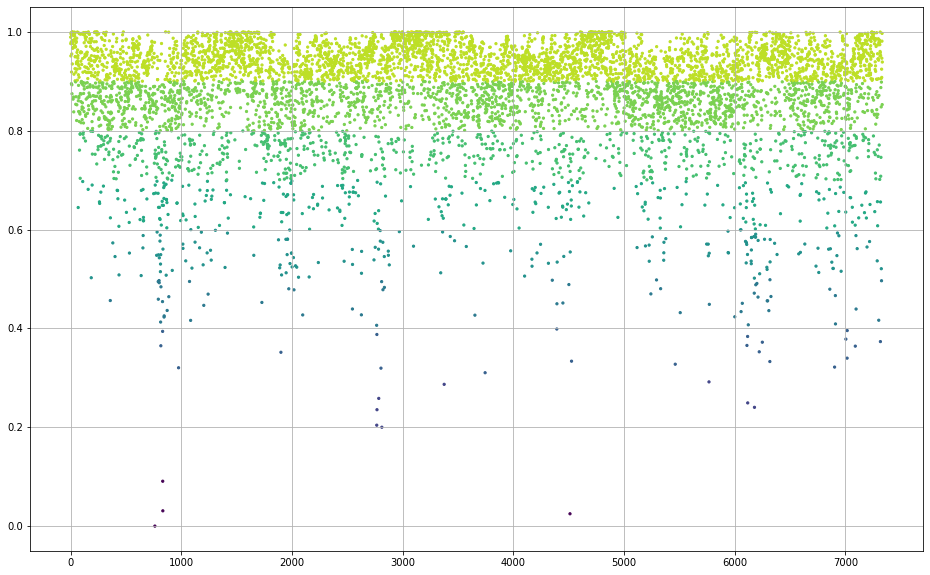

In [24]:
fig, ax = plt.subplots(figsize=(16,10))
im=ax.scatter(x=df.index,y=P,c=np.multiply(P,10).astype(int),s=5)
ax.grid(True)
plt.show()

In [26]:
#estimator.explain_outlier(1000)

#### Feature Importance

In [27]:
warnings.filterwarnings('ignore')
#k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, random_state=1))
k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, nsamples=1000, random_state=1))
X_test_sample=shap.sample(X_test,random_state=1)
k_shap_values = k_explainer.shap_values(X_test_sample) # More Sample Need more time
warnings.filterwarnings('once')

  0%|          | 0/100 [00:00<?, ?it/s]

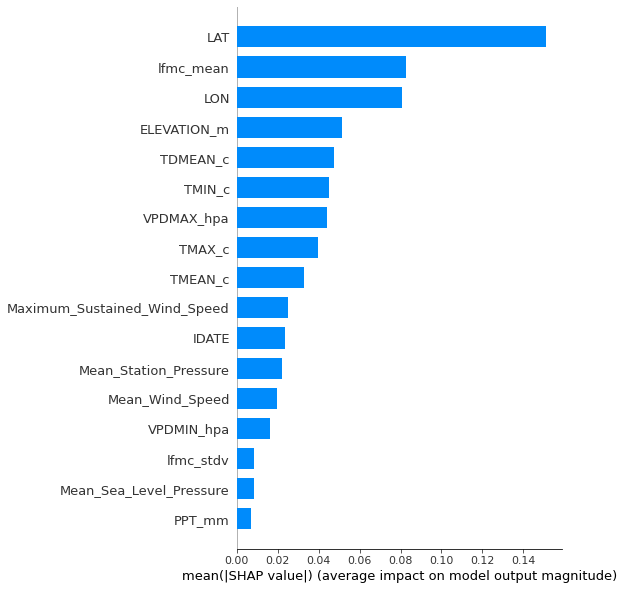

In [28]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample, plot_type="bar")

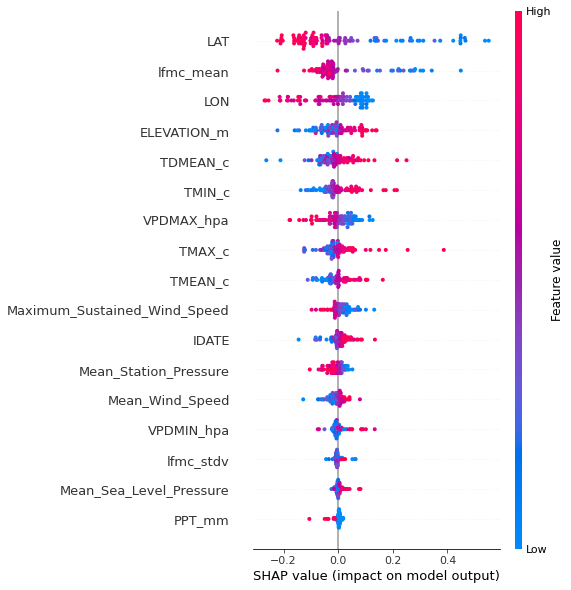

In [29]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample)

In [30]:
shap.initjs()
shap.force_plot(k_explainer.expected_value, k_shap_values, X_test_sample)

In [31]:
feature_names = X_train.columns
rf_resultX = pd.DataFrame(k_shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
#shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
0,IDATE,0.023584
1,LAT,0.151175
2,LON,0.080523
3,ELEVATION_m,0.051572
4,PPT_mm,0.007053
5,TMIN_c,0.045281
6,TMEAN_c,0.032755
7,TMAX_c,0.039844
8,TDMEAN_c,0.047526
9,lfmc_mean,0.082903
